In [4]:
library(readr)
library(dplyr)
# se non lo avete ancora installato decommentare -----
#install.packages("tidyr")
library(tidyr)
library(ggplot2)


Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union




## CON I FILES DIVISI PER HARDWARE

In [5]:
# --------------------------- consiglio di usare    "SW-106" !!!!!!!!!!!!!!!!!!!!!!!!!!    il file più leggero
hardware <- "SW-106" # leggi commento sopra!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# "SW-065" "SW-088" "SW-106" "SW-115"

# Percorso completo al file
file_path <- paste("/home/marco/Documenti/MAPD-B/DatasetProgetto/split_hwid/",hardware,".csv",sep='')

# Lettura efficiente del CSV
dataset <- read_csv(file_path)

Rows: 26187749 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): hwid, metric
dbl (2): when, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
dataset <- dataset %>%
  pivot_wider(
    names_from = metric,
    values_from = value
  ) %>%
  mutate(
    datetime = as.POSIXct(round(when / 1000), origin = "1970-01-01", tz = "UTC")
  ) %>%
  relocate(datetime, .before = everything())

# Rioridino con i tempi in modo crescente
dataset <- dataset %>% arrange(when)

In [7]:
dataset[1:10,c(1:12)] #seleziono alcune colonne per vedere meglio

datetime,when,hwid,S49,S50,S53,S54,S55,S56,S57,S63,S64
<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-10-01 00:00:22,1.601510e+12,SW-106,0,0,0,0,1,0,0,0,0
2020-10-01 00:00:25,1.601510e+12,SW-106,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-10-01 00:00:53,1.601510e+12,SW-106,0,0,0,0,1,0,0,0,0
2020-10-01 00:00:55,1.601510e+12,SW-106,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-10-01 00:01:23,1.601510e+12,SW-106,0,0,0,0,1,0,0,0,0
2020-10-01 00:01:26,1.601510e+12,SW-106,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-10-01 00:01:53,1.601511e+12,SW-106,0,0,0,0,1,0,0,0,0
2020-10-01 00:01:56,1.601511e+12,SW-106,NA,NA,NA,NA,NA,NA,NA,NA,NA
2020-10-01 00:02:23,1.601511e+12,SW-106,0,0,0,0,1,0,0,0,0


In [8]:
cat("Riempio gli NA con i valore più vicini nel tempo")
dataset <- dataset %>%
  fill(c(starts_with("S"), starts_with("P"), starts_with("A"), starts_with("ComError")), .direction = "downup")

Riempio gli NA con i valore più vicini nel tempo

In [9]:
# Calcola le differenze temporali
dataset <- dataset %>%
  mutate(time_diff = as.numeric(difftime(datetime, lag(datetime), units = "secs")))

# Rimuovi il primo valore NA (non ha precedente)
# yolo <- dataset[,c("datetime","S117")]
# yolo <- yolo %>%
# mutate(time_diff = as.numeric(difftime(datetime, lag(datetime), units = "secs")))
time_differences <- dataset$time_diff[!is.na(dataset$time_diff)]

# Muovo prima colonna la differenza tempi
dataset <- dataset %>% relocate(time_diff, .before = everything())

# Stampa la tabella delle differenze
cat("Statistiche delle differenze temporali (in secondi):\n")
print(summary(time_differences))

# Crea dataframe delle frequenze delle differenze temporali
time_diff_table <- table(time_differences)
freq_df <- data.frame(
  differenza_secondi = as.numeric(names(time_diff_table)),
  frequenza = as.numeric(time_diff_table)
)

Statistiche delle differenze temporali (in secondi):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2       3      23      38      27 5003774 


### prove Mattina 23 Luglio

In [10]:
# datasetyolo <- dataset[dataset$time_diff>80,]
# datasetyolo <- datasetyolo[2:nrow(datasetyolo),]
# print(datasetyolo,n=Inf)

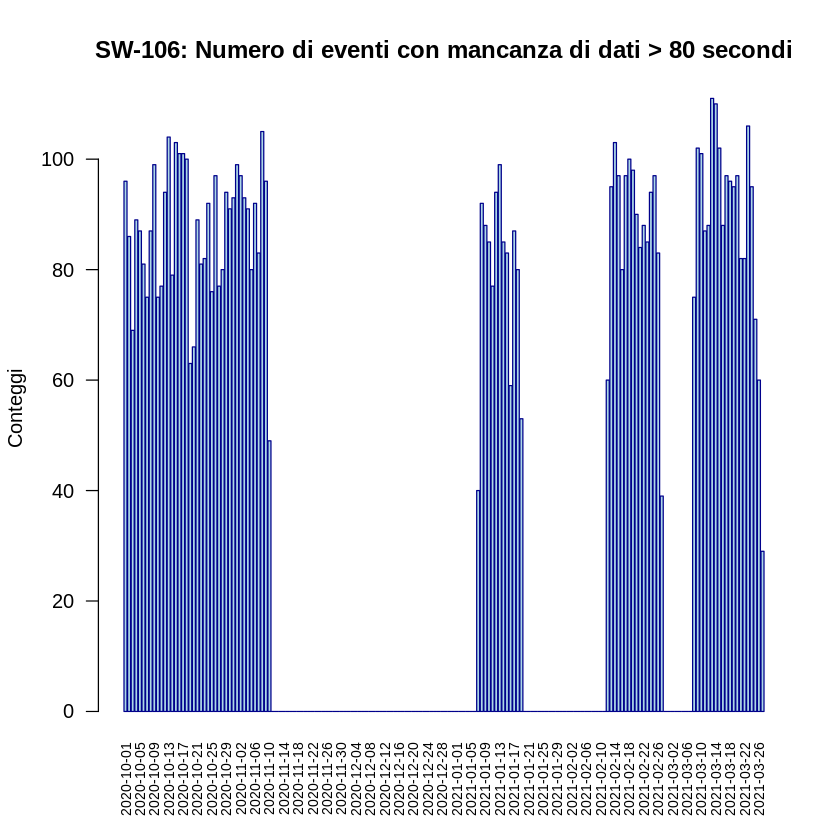

In [12]:
datasetyolo <- dataset[dataset$time_diff>80,]
datasetyolo <- datasetyolo[2:nrow(datasetyolo),]

# Assicurati che datetime sia in formato POSIXct
datasetyolo$datetime <- as.POSIXct(datasetyolo$datetime, format = "%Y-%m-%d %H:%M:%S")

# Estrai la data (senza l'ora)
datasetyolo$date <- as.Date(datasetyolo$datetime)

# Crea una sequenza completa di date
all_dates <- seq(min(datasetyolo$date), max(datasetyolo$date), by = "day")

# Conta gli eventi per giorno
daily_counts <- table(datasetyolo$date)

# Crea un vettore con tutti i giorni, inizialmente a 0
full_counts <- setNames(rep(0, length(all_dates)), as.character(all_dates))

# Inserisci i conteggi reali nei giorni presenti
full_counts[names(daily_counts)] <- daily_counts

# Traccia l'istogramma
barplot(full_counts,
        las = 2,                     # rotazione etichette asse x
        col = "lightblue",
        border = "darkblue",
        main = "SW-106: Numero di eventi con mancanza di dati > 80 secondi",
        xlab = "",
        ylab = "Conteggi",
        cex.names = 0.7)             # riduce dimensione etichette asse x


In [22]:
#dataset[183120:183160,]

In [23]:
#dataset[dataset$time_diff>200,]

In [24]:
#print(as.data.frame(dataset[100:150,c("time_diff","when")]), digits = 20)

In [30]:
dataset <- dataset %>% relocate(time_diff, .before = everything())
dataset[100:150,c(1:10,130:136)]

In [46]:
print_truncated <- function(df, n_head = 5, n_tail = 5) {
  dots_row <- tibble::as_tibble(lapply(df, function(x) rep("...", 1)))
  
  df_out <- bind_rows(
    dplyr::slice(df, 1:n_head),
    dots_row,
    dplyr::slice(df, (nrow(df) - n_tail + 1):nrow(df))
  )
  
  # Converte in data.frame per togliere la colonna di riga visiva
  print(as.data.frame(df_out), row.names = FALSE)
}
                                       
freq_df_string <- freq_df %>%
  mutate(across(everything(), as.character))

In [59]:
names(freq_df_string) <- c("Diff. temp. (s)","Conteggi")

In [121]:
freq_df[220:260,]

,differenza_secondi,frequenza
,<dbl>,<dbl>
220,245,10
221,246,11
222,247,12
223,248,8
224,249,11
225,250,3
226,251,5
227,252,8
228,253,4


In [78]:
cat("\nDifferenze temporali tra misure consecutive\n\n")
#freq_df[c(1:15,434:444),]
print_truncated(freq_df_string,1,25)


Differenze temporali tra misure consecutive

 Diff. temp. (s) Conteggi
               2    23800
             ...      ...
            2134        1
            2140        1
            2152        1
            2168        1
            2178        1
            2261        2
            2477        1
            2607        1
            2719        1
            2819        1
            3865        1
            3881        1
            3890        1
            3979        1
            4011        1
            4013        1
            4239        1
            5734        1
            8173        1
            8973        1
           28598        1
           48451        1
          757864        1
         2066908        1
         5003774        1


In [65]:
# cat("\nDifferenze temporali tra misure consecutive\n\n")
# #freq_df[c(1:15,434:444),]
# freq_df_string[200:230,]

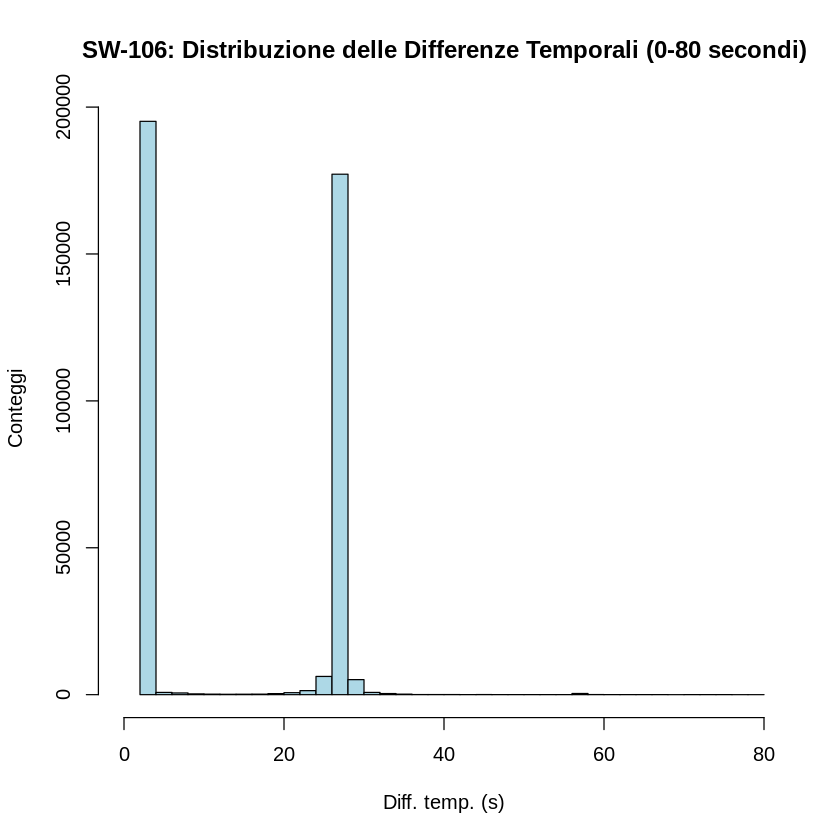

In [130]:
# Filtra i dati per l'istogramma (solo fino a 180 secondi)
time_diff_filtered <- time_differences[time_differences <= 80]

# Crea l'istogramma (solo fino a 180 secondi)
hist(time_diff_filtered, 
     main = "SW-106: Distribuzione delle Differenze Temporali (0-80 secondi)",
     xlab = "Diff. temp. (s)",
     ylab = "Conteggi",
     col = "lightblue",
     border = "black",
     breaks = 50,
     xlim = c(0, 80))

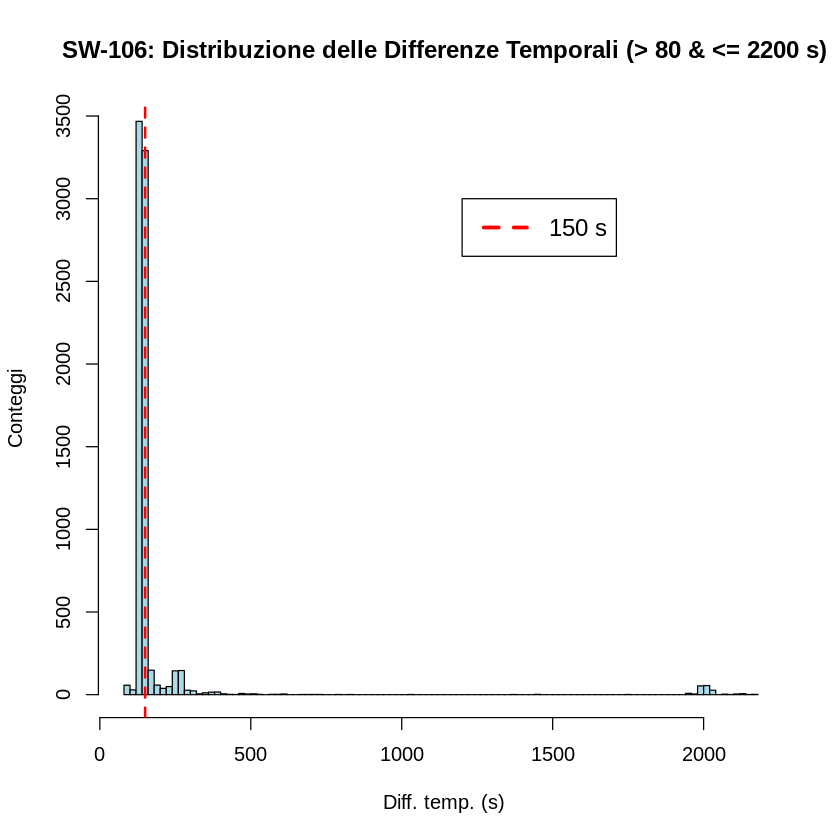

In [129]:
# Filtra i dati per l'istogramma
time_diff_filtered <- time_differences[time_differences > 80 & time_differences <= 2200]

# Crea l'istogramma
yolo <- hist(time_diff_filtered, 
     main = "SW-106: Distribuzione delle Differenze Temporali (> 80 & <= 2200 s)",
     xlab = "Diff. temp. (s)",
     ylab = "Conteggi",
     col = "lightblue",
     border = "black",
     breaks = 100,
     xlim = c(80, 2200)
     #xaxt = "n"  # <--- disattiva asse X automatico
)

# Aggiungi asse X personalizzato (da 80 a 2200, passo 200 ad es.)
#axis(side = 1, at = seq(80, 2200, by = 200))

abline(v=150,lty=2,col="red",lwd=2)
legend(1200,3000,"150 s",lty=2,col="red",lwd = 3,          # Linee più spesse
       cex = 1.2,        # Testo più grande
       pt.cex = 1.2,    ) # Simboli più grandi (se usi pch)) )

## CON I FILE SPLITTATI IN BASE ALLE RIGHE (MEGLIO QUELLO SOPRA, questa era la versione precedente)

In [148]:
# quale parte vuoi controllare?
i <- "13"

In [149]:
# Percorso completo al file
file_path <- paste("/home/marco/Documenti/MAPD-B/DatasetProgetto/In28parti/part_",i,".csv",sep='')

# Lettura efficiente del CSV
dataset <- read_csv(file_path)

Rows: 2102770 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): hwid, metric
dbl (2): when, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [150]:
dataset %>% slice_head(n = 5)

when,hwid,metric,value
<dbl>,<chr>,<chr>,<dbl>
1.616207e+12,SW-115,S86,89
1.616207e+12,SW-115,S83,-132
1.616207e+12,SW-115,S81,-132
1.616207e+12,SW-115,S80,0
1.616207e+12,SW-115,S73,1


In [151]:
hwid_list <- dataset %>%
  group_by(hwid) %>%
  group_split() %>%
  setNames(unique(dataset$hwid))

In [152]:
cat( "Gli hardware che ci sono qui dentro sono", names(hwid_list),"\n\n" )
# se vuoi elaborarare i dati per uno specifico hardware devi cambiare qua sotto
#df <- hwid_list[['SW-088']]
cat( "Preso il primo hardware che è", names(hwid_list)[1])
df <- hwid_list[[ names(hwid_list)[1] ]]

Gli hardware che ci sono qui dentro sono SW-115 

Preso il primo hardware che è SW-115

In [132]:
df

when,hwid,metric,value
<dbl>,<chr>,<chr>,<dbl>
1.610411e+12,SW-115,S45,0
1.610411e+12,SW-115,S43,0
1.610411e+12,SW-115,S42,0
1.610411e+12,SW-115,S41,67
1.610411e+12,SW-115,S40,212
1.610411e+12,SW-115,S39,212
1.610411e+12,SW-115,S37,350
1.610411e+12,SW-115,S35,0
1.610411e+12,SW-115,S34,0


In [9]:
df_pivot <- df %>%
  pivot_wider(
    names_from = metric,
    values_from = value
  ) %>%
  mutate(
    datetime = as.POSIXct(round(when / 1000), origin = "1970-01-01", tz = "UTC")
  ) %>%
  relocate(datetime, .before = everything())

In [10]:
cat("sono",length(names(df_pivot)),"colonne \n\n",names(df_pivot),sep=' ')

sono 136 colonne 

 when hwid S176 S178 S179 S180 S181 S183 S201 S102 S106 S107 S108 S109 S110 S112 S113 S114 S115 S117 S118 S122 S123 S124 S125 S126 S127 S128 S129 S5 S3 S6 S7 S8 S9 S10 S11 S15 S16 S17 S19 S25 S33 S34 S35 S37 S39 S40 S41 S42 S43 S45 S46 S47 S49 S2 S1 SW S50 S53 S54 S55 S56 S57 S63 S64 S69 S70 P1 P2 P5 P6 P7 P8 P9 P10 P15 P16 P17 P18 SA1 SA2 SA3 SA4 SA5 SA6 SA7 SA8 SA9 SA10 SA11 SA12 S71 S72 S73 S80 S81 S83 S86 S90 S94 S97 S100 S101 S204 S203 S202 S175 S174 S173 S172 S130 S137 S138 S140 S143 S147 S151 S154 S157 S158 S159 S163 S164 S165 S166 S167 S169 S206 S205 S171 S170 A5 A9 ComError datetime

In [23]:
df_pivot[,1:20] #seleziono alcune colonne per vedere meglio

datetime,when,hwid,S176,S178,S179,S180,S181,S183,S201,S102,S106,S107,S108,S109,S110,S112,S113,S114,S115
<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-03-06 11:48:29,1.615031e+12,SW-088,0,0,1,65358,0,0,7183,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-03-06 11:48:56,1.615031e+12,SW-088,NA,NA,NA,NA,NA,NA,NA,253,0,420,0,780,0,0,0,1,0
2021-03-06 11:48:59,1.615031e+12,SW-088,0,0,1,65358,0,0,7183,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-03-06 11:49:28,1.615031e+12,SW-088,NA,NA,NA,NA,NA,NA,NA,253,0,420,0,780,0,0,0,1,0
2021-03-06 11:49:31,1.615031e+12,SW-088,0,0,1,65358,0,0,7183,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-03-06 11:49:57,1.615031e+12,SW-088,NA,NA,NA,NA,NA,NA,NA,253,0,420,0,780,0,0,0,1,0
2021-03-06 11:50:00,1.615031e+12,SW-088,0,0,1,65360,0,0,7183,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2021-03-06 11:50:27,1.615031e+12,SW-088,NA,NA,NA,NA,NA,NA,NA,253,0,420,0,780,0,0,0,1,0
2021-03-06 11:50:29,1.615031e+12,SW-088,0,0,1,65362,0,0,7183,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [36]:
cat("Riempio gli NA con i valore più vicini nel tempo")
df_filled <- df_pivot %>%
  arrange(datetime) %>%
  fill(starts_with("S"), .direction = "downup") 

Riempio gli NA con i valore più vicini nel tempo

In [39]:
df_filled[1:10]

datetime,when,hwid,S176,S178,S179,S180,S181,S183,S201
<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-03-06 11:48:29,1.615031e+12,SW-088,0,0,1,65358,0,0,7183
2021-03-06 11:48:56,1.615031e+12,SW-088,0,0,1,65358,0,0,7183
2021-03-06 11:48:59,1.615031e+12,SW-088,0,0,1,65358,0,0,7183
2021-03-06 11:49:28,1.615031e+12,SW-088,0,0,1,65358,0,0,7183
2021-03-06 11:49:31,1.615031e+12,SW-088,0,0,1,65358,0,0,7183
2021-03-06 11:49:57,1.615031e+12,SW-088,0,0,1,65358,0,0,7183
2021-03-06 11:50:00,1.615031e+12,SW-088,0,0,1,65360,0,0,7183
2021-03-06 11:50:27,1.615031e+12,SW-088,0,0,1,65360,0,0,7183
2021-03-06 11:50:29,1.615031e+12,SW-088,0,0,1,65362,0,0,7183


In [45]:
# Calcola le differenze temporali
df_filled <- df_filled %>%
  arrange(datetime) %>%  # Assicurati che i dati siano ordinati per tempo
  mutate(time_diff = as.numeric(difftime(datetime, lag(datetime), units = "secs")))

# Rimuovi il primo valore NA (non ha precedente)
time_differences <- df_filled$time_diff[!is.na(df_filled$time_diff)]

# Stampa la tabella delle differenze
cat("Statistiche delle differenze temporali (in secondi):\n")
print(summary(time_differences))

# Crea dataframe delle frequenze delle differenze temporali
time_diff_table <- table(time_differences)
freq_df <- data.frame(
  differenza_secondi = as.numeric(names(time_diff_table)),
  frequenza = as.numeric(time_diff_table)
)

Statistiche delle differenze temporali (in secondi):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2       3      17      31      28  722055 


In [46]:
cat("\nDataframe delle frequenze delle differenze temporali:\n")
freq_df


Dataframe delle frequenze delle differenze temporali:


differenza_secondi,frequenza
<dbl>,<dbl>
2,12351
3,20482
4,1355
5,283
6,125
7,89
8,86
9,89
10,93


In [47]:
# Se vuoi vedere anche i primi valori della tabella completa
cat("\nPrime 10 righe con le differenze temporali:\n")
head(df_filled[, c("datetime", "time_diff")], 10)


Prime 10 righe con le differenze temporali:


datetime,time_diff
<dttm>,<dbl>
2021-03-06 11:48:29,NA
2021-03-06 11:48:56,27
2021-03-06 11:48:59,3
2021-03-06 11:49:28,29
2021-03-06 11:49:31,3
2021-03-06 11:49:57,26
2021-03-06 11:50:00,3
2021-03-06 11:50:27,27
2021-03-06 11:50:29,2


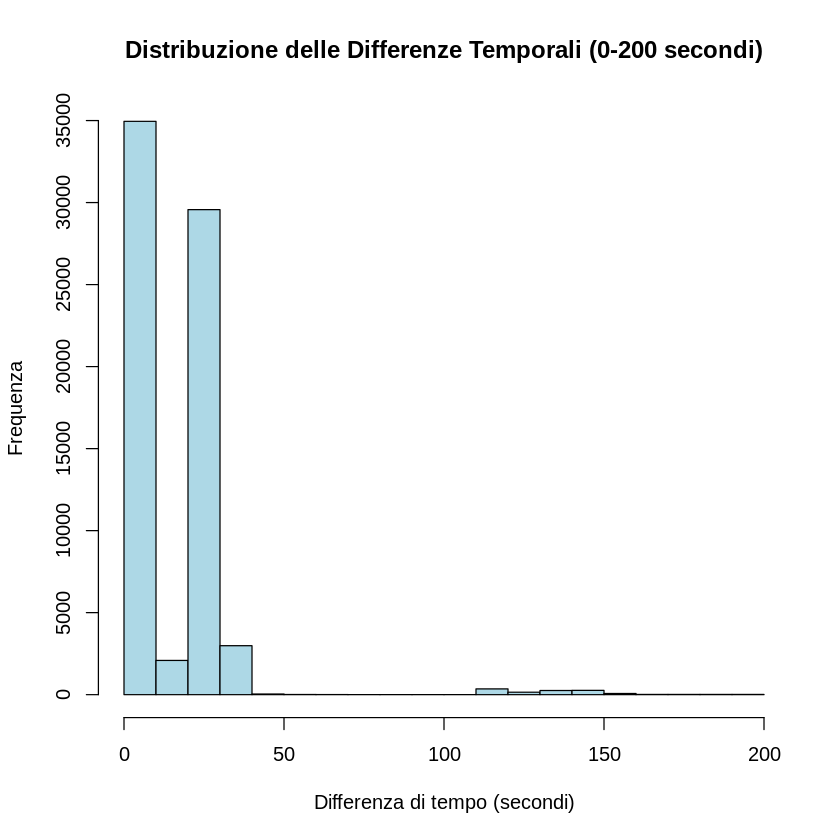

In [43]:
# Filtra i dati per l'istogramma (solo fino a 200 secondi)
time_diff_filtered <- time_differences[time_differences <= 200]

# Crea l'istogramma (solo fino a 200 secondi)
hist(time_diff_filtered, 
     main = "Distribuzione delle Differenze Temporali (0-200 secondi)",
     xlab = "Differenza di tempo (secondi)",
     ylab = "Frequenza",
     col = "lightblue",
     border = "black",
     breaks = 20,
     xlim = c(0, 200))